### TFM - Predicción de los precios de Alquiler a partir de las características.

Importación de librerías necesarias para el desarrollo.


In [ ]:
# Import de todo las librerías que podemos llegar a usar.
import pandas as pd
import io
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

from scipy import cluster
import sklearn.neighbors
from sklearn import preprocessing 
from sklearn.decomposition import PCA

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import kneighbors_graph

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None
%matplotlib inline

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# División aleatoria pero con la librería model_selection
from sklearn.model_selection import train_test_split 

Hacemos esa primera lectura del dataset, contar, filas, columnas, tipos de datos.

In [ ]:
#Lectura del dataset
pisos_bilbao = pd.read_csv('/content/pisos_bilbao.csv', ',' , encoding= 'unicode_escape')
pisos_bilbao.head(5)

,Habitaciones,Banhos,Superficie,Barrio,Renta,Precio
0,2,1,75,8,18165,750
1,1,1,45,0,40300,780
2,4,2,220,0,40300,1550
3,3,2,87,1,40401,1200
4,1,1,45,0,40300,950


#### Tres variables.

##### Regresión 

primero tenemos que preparar los ficheros, separarlos en train y test, separar las etiquetas del fichero para poder entrenar el modelo.

In [ ]:
Bilbao_train, Bilbao_test = train_test_split(pisos_bilbao, test_size = 0.20, random_state = 78)
# Advertir de los parámetros interesantes como stratify

print("Ejemplos usados para entrenar: ", len(Bilbao_train))
print("Ejemplos usados para test: ", len(Bilbao_test))

Ejemplos usados para entrenar:  448
Ejemplos usados para test:  112


In [ ]:
y_train = Bilbao_train['Precio']
y_test = Bilbao_test['Precio']

In [ ]:
y_train.describe()

count     448.000000
mean     1109.569196
std       351.877851
min       360.000000
25%       850.000000
50%      1000.000000
75%      1200.000000
max      3000.000000
Name: Precio, dtype: float64

In [ ]:
y_test.describe()

count     112.000000
mean     1181.964286
std       484.407485
min       700.000000
25%       890.000000
50%      1100.000000
75%      1300.000000
max      5000.000000
Name: Precio, dtype: float64

In [ ]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie'   
                    ]

In [ ]:
# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])


In [ ]:
rl_a = linear_model.LinearRegression()
rl_a.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = rl_a.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rl_a = np.hstack(y)
resultado_rl_a = r2_score(y_test, resultado_rl_a)
resultado_rl_a

0.6209904618726518

In [ ]:
kf = KFold(n_splits=5)
score = rl_a.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_a, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.4713325337253342
Metricas cross_validation [0.26249076 0.26525351 0.48640281 0.58921743 0.35565301]
Media de cross_validation 0.3918035020014984


##### Arbol

In [ ]:
ad_a = DecisionTreeRegressor(criterion='r2', max_depth=5, random_state=78, max_features='sqrt')
ad_a

DecisionTreeRegressor(ccp_alpha=0.0, criterion='r2', max_depth=5,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=78, splitter='best')

In [ ]:
# constructor
ad_a = DecisionTreeRegressor(criterion='mae', max_depth =5, random_state=78, max_features='sqrt')
# fit and predict

ad_a.fit(Bilbao_train[selected_features], y_train)
y_pred = ad_a.predict(Bilbao_test[selected_features])
 
# Redondeamos y tranformamos en entero el resultado final
y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ad_a = np.hstack(y)

resultado_ad_a = r2_score(y_test, resultado_ad_a)
resultado_ad_a

0.3024689381142668

In [ ]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
dot_data = export_graphviz(ad_a,
                           feature_names=selected_features)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

In [ ]:
kf = KFold(n_splits=5)
score = ad_a.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_a, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5721603928144288
Metricas cross_validation [0.38203973 0.50225375 0.37699363 0.60436179 0.14349006]
Media de cross_validation 0.40182779196631574


##### SVR

In [ ]:
svr_a = SVR(kernel='linear', C=20, epsilon=1)

svr_a.fit(X_train, y_train)

Bilbao_test_svr=X_test
y_pred = svr_a.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_svr_a = np.hstack(y)

resultado_svr_a = r2_score(y_test, resultado_svr_a)
resultado_svr_a

0.5629298632746377

In [ ]:
kf = KFold(n_splits=5)
score = svr_a.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(svr_a, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.43647293230719464
Metricas cross_validation [0.27230154 0.27930285 0.47814288 0.56168134 0.3827233 ]
Media de cross_validation 0.3948303801922046


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


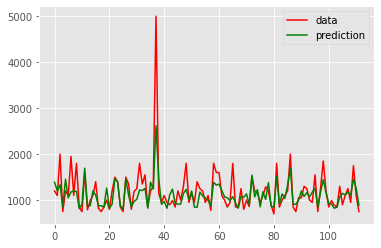

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### Gradient Boosting

In [ ]:
gb_a = GradientBoostingRegressor(n_estimators=5, max_features='auto', random_state=78, learning_rate=0.5, 
                                min_samples_split=20, min_samples_leaf=4, max_depth=5)

gb_a.fit(Bilbao_train[selected_features], y_train)

Bilbao_test_svr=Bilbao_test[selected_features]
y_pred = gb_a.predict(Bilbao_test_svr)
 
y = np.rint(y_pred) 
y = y.astype(int) 
resultado_gb_a = np.hstack(y)

resultado_gb_a = r2_score(y_test, resultado_gb_a)
resultado_gb_a

0.45497921894610127

In [ ]:
kf = KFold(n_splits=5)
score = gb_a.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_a, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.6369677174179378
Metricas cross_validation [0.22685533 0.36835069 0.51521779 0.50479488 0.42380688]
Media de cross_validation 0.4078051141101864


##### lasso

In [ ]:
ls_a = Lasso(alpha=0.001, random_state=78)
ls_a.fit(X_train, y_train)
y_pred = ls_a.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ls_a = np.hstack(y)
resultado_ls_a = r2_score(y_test, resultado_ls_a)
resultado_ls_a

0.6209904618726518

In [ ]:
kf = KFold(n_splits=5)
score = ls_a.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ls_a, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.47133253364479577
Metricas cross_validation [0.26249203 0.26525785 0.48640284 0.5892142  0.35565802]
Media de cross_validation 0.39180498555863286


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


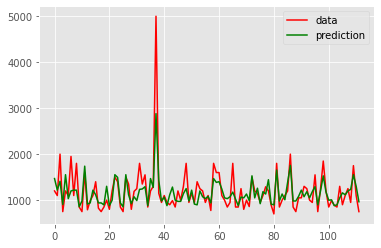

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### Ridge

In [ ]:
rg_a = Ridge(alpha=1, random_state=78,fit_intercept = True)
rg_a.fit(X_train, y_train)
y_pred = rg_a.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rg_a = np.hstack(y)
resultado_rg_a = r2_score(y_test, resultado_rg_a)
resultado_rg_a

0.6202171442220634

In [ ]:
kf = KFold(n_splits=5)
score = rg_a.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rg_a, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.4713237710857369
Metricas cross_validation [0.26343431 0.26534933 0.48639294 0.58776961 0.3583515 ]
Media de cross_validation 0.3922595366725044


##### ElasticNet

In [ ]:
en_a = ElasticNet(alpha=2, l1_ratio = 1, random_state=78,fit_intercept = True)
en_a.fit(X_train, y_train)
y_pred = en_a.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_en_a = np.hstack(y)
resultado_en_a = r2_score(y_test, resultado_en_a)
resultado_en_a

0.6201430067787466

In [ ]:
kf = KFold(n_splits=5)
score = en_a.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(en_a, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.47109665021531066
Metricas cross_validation [0.25954529 0.27392831 0.48560735 0.58247079 0.36534145]
Media de cross_validation 0.39337863834914105


#### Tres Variables más barrio

##### Regresion

In [ ]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Barrio'  
                    ]

In [ ]:
# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_b = linear_model.LinearRegression()
rl_b.fit(X_train, y_train)

y_pred = rl_b.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rl_b = np.hstack(y)
resultado_rl_b = r2_score(y_test, resultado_rl_b)
resultado_rl_b

0.6424437109802478

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


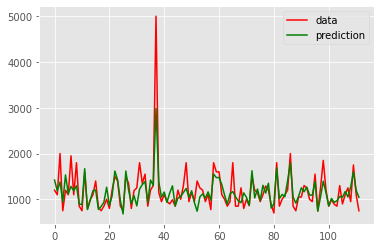

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

In [ ]:
kf = KFold(n_splits=5)
score = rl_b.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_b, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5271231008722299
Metricas cross_validation [0.3646798  0.31738143 0.53102345 0.6380149  0.42211199]
Media de cross_validation 0.4546423110271425


##### Arbol

In [ ]:
ad_b = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=78, max_features='sqrt')

In [ ]:
ad_b.fit(Bilbao_train[selected_features], y_train)
print ('Características relevantes')
pd.DataFrame({'Attributes': selected_features ,
              'Decision Tree': ad_b.feature_importances_})

Características relevantes


,Attributes,Decision Tree
0,Habitaciones,0.143325
1,Banhos,0.065707
2,Superficie,0.715236
3,Barrio,0.075732


In [ ]:
# constructor
ad_b = DecisionTreeRegressor(criterion='mae', max_depth=6, random_state=78, max_features='sqrt')
# fit and predict

ad_b.fit(Bilbao_train[selected_features], y_train)
y_pred = ad_b.predict(Bilbao_test[selected_features])

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ad_b = np.hstack(y)

resultado_ad_b = r2_score(y_test, resultado_ad_b)
resultado_ad_b

0.5892915025639176

In [ ]:
kf = KFold(n_splits=5)
score = ad_b.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_b, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.6793581522518418
Metricas cross_validation [0.39713415 0.34423438 0.51906466 0.39882919 0.17804466]
Media de cross_validation 0.36746140857859394


##### SVR

In [ ]:
svr_b = SVR(kernel='linear', C=10, epsilon=1.5)

svr_b.fit(X_train, y_train)

Bilbao_test_svr=X_test
y_pred = svr_b.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_svr_b = np.hstack(y)

resultado_svr_b = r2_score(y_test, resultado_svr_b)
resultado_svr_b

0.5974203219249956

In [ ]:
kf = KFold(n_splits=5)
score = svr_b.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(svr_b, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5027263831946296
Metricas cross_validation [0.37657938 0.35209938 0.52687316 0.61329785 0.43291797]
Media de cross_validation 0.46035354586592536


##### Gradient Boosting

In [ ]:
gb_b = GradientBoostingRegressor(n_estimators=7, max_features='auto', random_state=78, learning_rate=0.5, 
                                min_samples_split=20, min_samples_leaf=5, max_depth=5)

gb_b.fit(Bilbao_train[selected_features], y_train)

Bilbao_test_svr=Bilbao_test[selected_features]
y_pred = gb_b.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_gb_b = np.hstack(y)

resultado_gb_b = r2_score(y_test, resultado_gb_b)
resultado_gb_b

0.44851167725064534

In [ ]:
kf = KFold(n_splits=5)
score = gb_b.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_b, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7340970452396174
Metricas cross_validation [0.47300286 0.48787198 0.51697232 0.58181388 0.39203518]
Media de cross_validation 0.4903392422029394


##### lasso

In [ ]:
ls_b = Lasso(alpha=0.001, random_state=78)
ls_b.fit(X_train, y_train)
y_pred = ls_b.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ls_b = np.hstack(y)
resultado_ls_b = r2_score(y_test, resultado_ls_b)
resultado_ls_b

0.6424437109802478

In [ ]:
kf = KFold(n_splits=5)
score = ls_b.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ls_b, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5271231008091674
Metricas cross_validation [0.36468019 0.31738275 0.53102389 0.63801183 0.42211588]
Media de cross_validation 0.454642908639222


##### Ridge

In [ ]:
rg_b = Ridge(alpha=0.001, random_state=78,fit_intercept = True)
rg_b.fit(X_train, y_train)
y_pred = rg_b.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rg_b = np.hstack(y)
resultado_rg_b = r2_score(y_test, resultado_rg_b)
resultado_rg_b

0.6424437109802478

In [ ]:
kf = KFold(n_splits=5)
score = rg_b.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rg_b, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5271231008650894
Metricas cross_validation [0.36468095 0.31738188 0.53102329 0.63801368 0.42211395]
Media de cross_validation 0.4546427482751776


##### ElasticNet

In [ ]:
en_b = ElasticNet(alpha=2, l1_ratio = 1, random_state=78,fit_intercept = True)
en_b.fit(X_train, y_train)
y_pred = en_b.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_en_b = np.hstack(y)
resultado_en_b = r2_score(y_test, resultado_en_b)
resultado_en_b

0.6418275754596121

In [ ]:
kf = KFold(n_splits=5)
score = en_b.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(en_b, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5268798664899903
Metricas cross_validation [0.36273797 0.32870688 0.52914779 0.63164239 0.42954694]
Media de cross_validation 0.4563563949278704


#### Tres Variables más renta

##### Regresión

In [ ]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Renta'  
                    ]

In [ ]:
# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_c = linear_model.LinearRegression()
rl_c.fit(X_train, y_train)

y_pred = rl_c.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rl_c = np.hstack(y)
resultado_rl_c = r2_score(y_test, resultado_rl_c)
resultado_rl_c

0.6442582162669352

In [ ]:
kf = KFold(n_splits=5)
score = rl_c.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_c, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5264479951553895
Metricas cross_validation [0.36381056 0.33919551 0.53473268 0.63425196 0.41630378]
Media de cross_validation 0.4576588986736302


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


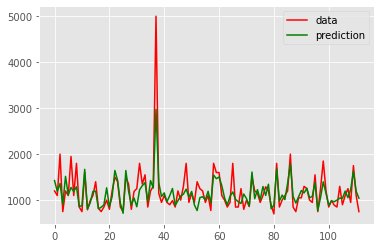

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### Arbol

In [ ]:
ad_c = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=78, max_features='sqrt')

In [ ]:
ad_c.fit(Bilbao_train[selected_features], y_train)
print ('Características relevantes')
pd.DataFrame({'Attributes': selected_features ,
              'Decision Tree': ad_c.feature_importances_})

Características relevantes


,Attributes,Decision Tree
0,Habitaciones,0.172287
1,Banhos,0.092062
2,Superficie,0.635979
3,Renta,0.099671


In [ ]:
# constructor
ad_c = DecisionTreeRegressor(criterion='mae', max_depth=6, random_state=78, max_features='sqrt')
# fit and predict

ad_c.fit(Bilbao_train[selected_features], y_train)
y_pred = ad_c.predict(Bilbao_test[selected_features])

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ad_c = np.hstack(y)

resultado_ad_c = r2_score(y_test, resultado_ad_c)
resultado_ad_c

0.40273685472020126

In [ ]:
kf = KFold(n_splits=5)
score = ad_c.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_c, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.671789718467909
Metricas cross_validation [0.29623429 0.11280079 0.4009221  0.5354176  0.34124432]
Media de cross_validation 0.3373238185943806


##### SVR

In [ ]:
svr_c = SVR(kernel='linear', C=10, epsilon=1.5)

svr_c.fit(X_train, y_train)

Bilbao_test_svr=X_test
y_pred = svr_c.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_svr_c = np.hstack(y)

resultado_svr_c = r2_score(y_test, resultado_svr_c)
resultado_svr_c

0.6028097416392096

In [ ]:
kf = KFold(n_splits=5)
score = svr_c.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(svr_c, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.4987807972958397
Metricas cross_validation [0.36219585 0.37378561 0.53051037 0.6051447  0.43073515]
Media de cross_validation 0.4604743348390635


##### GradientBoosting

In [ ]:
gb_c = GradientBoostingRegressor(n_estimators=5, max_features='auto', random_state=78, learning_rate=0.5, 
                                min_samples_split=10, min_samples_leaf=5, max_depth=6)
gb_c.fit(Bilbao_train[selected_features], y_train)

Bilbao_test_svr=Bilbao_test[selected_features]
y_pred = gb_c.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_gb_c = np.hstack(y)

resultado_gb_c = r2_score(y_test, resultado_gb_c)
resultado_gb_c

0.47135054020044853

In [ ]:
kf = KFold(n_splits=5)
score = gb_c.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_c, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7354160881096966
Metricas cross_validation [0.4562502  0.56277148 0.52675288 0.57428428 0.41900904]
Media de cross_validation 0.5078135772835531


##### lasso

In [ ]:
ls_c = Lasso(alpha=0.001, random_state=78)
ls_c.fit(X_train, y_train)
y_pred = ls_c.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ls_c = np.hstack(y)
resultado_ls_c = r2_score(y_test, resultado_ls_c)
resultado_ls_c

0.6442582162669352

In [ ]:
kf = KFold(n_splits=5)
score = ls_c.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ls_c, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5264479950836755
Metricas cross_validation [0.36381184 0.33920045 0.53473234 0.63424898 0.41630754]
Media de cross_validation 0.4576602314236979


##### Ridge

In [ ]:
rg_c = Ridge(alpha=0.001, random_state=78,fit_intercept = True)
rg_c.fit(X_train, y_train)
y_pred = rg_c.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rg_c = np.hstack(y)
resultado_rg_c = r2_score(y_test, resultado_rg_c)
resultado_rg_c

0.6442582162669352

In [ ]:
kf = KFold(n_splits=5)
score = rg_c.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rg_c, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5264479951480052
Metricas cross_validation [0.3638117  0.3391958  0.53473259 0.63425074 0.41630565]
Media de cross_validation 0.45765929616517526


##### ElasticNet

In [ ]:
en_c = ElasticNet(alpha=2, l1_ratio = 1, random_state=78,fit_intercept = True)
en_c.fit(X_train, y_train)
y_pred = en_c.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_en_c = np.hstack(y)
resultado_en_c = r2_score(y_test, resultado_en_c)
resultado_en_c

0.6436597800530677

In [ ]:
kf = KFold(n_splits=5)
score = en_c.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(en_c, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5262048331997713
Metricas cross_validation [0.36185254 0.3498043  0.53324689 0.62785731 0.42350081]
Media de cross_validation 0.4592523685911328


#### Tres Variables más barrio más renta

##### Regresión 

In [ ]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Barrio', 'Renta'
                    ]

In [ ]:
# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_d = linear_model.LinearRegression()
rl_d.fit(X_train, y_train)

y_pred = rl_d.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rl_d = np.hstack(y)
resultado_rl_d = r2_score(y_test, resultado_rl_d)
resultado_rl_d

0.6438472928822541

In [ ]:
kf = KFold(n_splits=5)
score = rl_d.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_d, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5277431722405419
Metricas cross_validation [0.36596459 0.31859226 0.53293934 0.63662196 0.41909326]
Media de cross_validation 0.45464228160211767


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


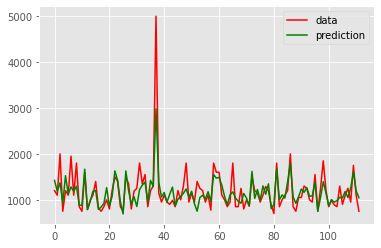

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### Arbol

In [ ]:
ad_d = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=78, max_features='sqrt')

In [ ]:
# constructor
ad_d = DecisionTreeRegressor(criterion='mae', max_depth=4, random_state=78, max_features='sqrt')
# fit and predict

ad_d.fit(Bilbao_train[selected_features], y_train)
y_pred = ad_d.predict(Bilbao_test[selected_features])

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ad_d = np.hstack(y)

resultado_ad_d = r2_score(y_test, resultado_ad_d)
resultado_ad_d

0.5155553843092929

In [ ]:
kf = KFold(n_splits=5)
score = ad_d.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_d, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5166134505012514
Metricas cross_validation [0.22864549 0.17402097 0.50879823 0.59511049 0.41969996]
Media de cross_validation 0.3852550272114543


##### SVR

In [ ]:
svr_d = SVR(kernel='linear', C=10, epsilon=1.5)

svr_d.fit(X_train, y_train)

Bilbao_test_svr=X_test
y_pred = svr_d.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_svr_d = np.hstack(y)

resultado_svr_d = r2_score(y_test, resultado_svr_d)
resultado_svr_d

0.6043999533247286

In [ ]:
kf = KFold(n_splits=5)
score = svr_d.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(svr_d, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5038803121748667
Metricas cross_validation [0.37626482 0.35624756 0.53105757 0.61091625 0.43946811]
Media de cross_validation 0.46279086017651705


##### Gradiente Boosting

In [ ]:
gb_d = GradientBoostingRegressor(n_estimators=6, max_features='auto', random_state=78, learning_rate=0.5, 
                                min_samples_split=15, min_samples_leaf=5)

gb_d.fit(Bilbao_train[selected_features], y_train)

Bilbao_test_svr=Bilbao_test[selected_features]
y_pred = gb_d.predict(Bilbao_test_svr)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_gb_d = np.hstack(y)

resultado_gb_d = r2_score(y_test, resultado_gb_d)
resultado_gb_d

0.5009208987156208

In [ ]:
kf = KFold(n_splits=5)
score = gb_d.score(Bilbao_train[selected_features],y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_d, Bilbao_train[selected_features], y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.6647371452055293
Metricas cross_validation [0.46739544 0.56879176 0.55459436 0.6422278  0.43523447]
Media de cross_validation 0.533648768117836


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


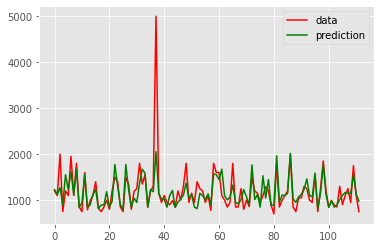

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### lasso

In [ ]:
ls_d = Lasso(alpha=0.001, random_state=78)
ls_d.fit(X_train, y_train)
y_pred = ls_d.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_ls_d = np.hstack(y)
resultado_ls_d = r2_score(y_test, resultado_ls_d)
resultado_ls_d

0.6438535509885517

In [ ]:
kf = KFold(n_splits=5)
score = ls_d.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ls_d, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5277431721239783
Metricas cross_validation [0.36596388 0.31859445 0.53293793 0.63661951 0.41909864]
Media de cross_validation 0.45464288087409904


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


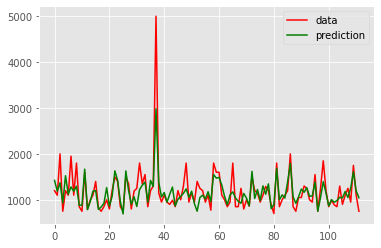

In [ ]:
xx = np.stack(i for i in range(Bilbao_test['Precio'].shape[0]))
plt.plot(xx, Bilbao_test['Precio'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()

plt.show()

##### Ridge

In [ ]:
rg_d = Ridge(alpha=0.001, random_state=78,fit_intercept = True)
rg_d.fit(X_train, y_train)
y_pred = rg_d.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_rg_d = np.hstack(y)
resultado_rg_d = r2_score(y_test, resultado_rg_d)
resultado_rg_d

0.6438472928822541

In [ ]:
kf = KFold(n_splits=5)
score = rg_d.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rg_d, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.5277431722332686
Metricas cross_validation [0.3659658  0.31859369 0.53293926 0.63662079 0.41909527]
Media de cross_validation 0.4546429639975201


##### ElasticNet

In [ ]:
en_d = ElasticNet(alpha=2, l1_ratio = 1, random_state=78,fit_intercept = True)
en_d.fit(X_train, y_train)
y_pred = en_d.predict(X_test)

y = np.rint(y_pred) 
y = y.astype(int) 
resultado_en_d = np.hstack(y)
resultado_en_d = r2_score(y_test, resultado_en_d)
resultado_en_d

0.6431385527457303

In [ ]:
kf = KFold(n_splits=5)
score = en_d.score(X_train,y_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(en_d, X_train, y_train, cv=kf, scoring="r2")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.527499797276326
Metricas cross_validation [0.36401632 0.32977093 0.53104531 0.6302441  0.42629331]
Media de cross_validation 0.4562739918939204


In [ ]:
resultados_a = [resultado_rl_a, resultado_ad_a, resultado_svr_a, 
                  resultado_gb_a, resultado_ls_a, resultado_rg_a, resultado_en_a]
labels = ['Regresion lineal', 'Árbol de decisión', 'SVR', 'Gradient Boosting',
           'Lasso', 'Ridge',  'ElasticNet']

scoreModels = pd.DataFrame({'Models': labels,
                            'resultados': resultados})
scoreModels.sort_values(by = 'resultados', ascending = False)

,Models,resultados
0,Regresion lineal,0.620990
4,Lasso,0.620990
5,Ridge,0.620217
6,ElasticNet,0.620143
2,SVR,0.562930
3,Gradient Boosting,0.454979
1,Árbol de decisión,0.330174


In [ ]:
resultados_b = [resultado_rl_b, resultado_ad_b, resultado_svr_b, 
                  resultado_gb_b, resultado_ls_b, resultado_rg_b, resultado_en_b]
labels = ['Regresion lineal', 'Árbol de decisión', 'SVR', 'Gradient Boosting',
           'Lasso', 'Ridge',  'ElasticNet']

scoreModels = pd.DataFrame({'Models': labels,
                            'resultados': resultados_b})
scoreModels.sort_values(by = 'resultados', ascending = False)

,Models,resultados
0,Regresion lineal,0.642444
4,Lasso,0.642444
5,Ridge,0.642444
6,ElasticNet,0.641828
2,SVR,0.597420
1,Árbol de decisión,0.589292
3,Gradient Boosting,0.448512


In [ ]:
resultados_c = [resultado_rl_c, resultado_ad_c, resultado_svr_c, 
                  resultado_gb_c, resultado_ls_c, resultado_rg_c, resultado_en_c]
labels = ['Regresion lineal', 'Árbol de decisión', 'SVR', 'Gradient Boosting',
           'Lasso', 'Ridge',  'ElasticNet']

scoreModels = pd.DataFrame({'Models': labels,
                            'resultados': resultados_c})
scoreModels.sort_values(by = 'resultados', ascending = False)

,Models,resultados
0,Regresion lineal,0.644258
4,Lasso,0.644258
5,Ridge,0.644258
6,ElasticNet,0.643660
2,SVR,0.602810
3,Gradient Boosting,0.471351
1,Árbol de decisión,0.402737


In [ ]:
resultados_d = [resultado_rl_d, resultado_ad_d, resultado_svr_d, 
                  resultado_gb_d, resultado_ls_d, resultado_rg_d, resultado_en_d]
labels = ['Regresion lineal', 'Árbol de decisión', 'SVR', 'Gradient Boosting',
           'Lasso', 'Ridge',  'ElasticNet']

scoreModels = pd.DataFrame({'Models': labels,
                            'resultados': resultados_d})
scoreModels.sort_values(by = 'resultados', ascending = False)

,Models,resultados
4,Lasso,0.643854
0,Regresion lineal,0.643847
5,Ridge,0.643847
6,ElasticNet,0.643139
2,SVR,0.604400
1,Árbol de decisión,0.515555
3,Gradient Boosting,0.500921
